# Implémentation en diverses étapes de l'algorithme deepDTnet

In [ ]:
import numpy as np
import torch
import torch.autograd as ag
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from scipy.optimize import minimize, NonlinearConstraint
import random

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from math import sqrt
import time

In [ ]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed

### Computing co-occurence matrices (PCO) with random surfing with return

In [ ]:
def normalize(M):
    #Put diagonal elements to 0
    M  = M - np.diag(np.diag(M))
    
    #Normalizing by row
    D_inv = np.diag(np.reciprocal(np.sum(M,axis=0)))
    M = np.dot(D_inv,  M)

    return M

In [ ]:
def PCO(A, K, alpha):
    """
    For a graph represented by its adjacency matrix *A*, computes the co-occurence matrix by random 
    surfing on the graph with returns. 1-alpha is the probability to make, at each step, a return 
    to the original step.
    """
    A=np.array(A, dtype=float)
    
    #The adjacency matrix A is first normalized
    A=normalize(A) 
    
    n=A.shape[0]
    
    I=np.eye(n)
    
    P=I
    M=np.zeros((n, n))
    
    for i in range(K):
        P = alpha*np.dot(P,A) + (1-alpha)*I
        M = M+P
    
    return(M)

In [ ]:
PCO([[0,1,1],[1,0,1],[1,1,0]], 4, 0.6)

array([[2.0482, 0.9759, 0.9759],
       [0.9759, 2.0482, 0.9759],
       [0.9759, 0.9759, 2.0482]])

### From co-occurence matrices (PCO) to shifted positive pointwise mutual information (PPMI) 

In [ ]:
def PPMI(M):
    """Computes the shifted positive pointwise mutual information (PPMI) matrix
    from the co-occurence matrix (PCO) of a graph."""
    
    M=normalize(M)
    cols = np.sum(M, axis=0)
    rows = np.sum(M, axis=1).reshape((-1,1))
    s = np.sum(rows)
    
    P = s*M
    P /= cols
    P /= rows
    
    #P[np.where(P<0)] = 1.0
    P = np.log(P)

    #To avoid NaN when applying log
    P[np.isnan(P)] = 0.0
    P[np.isinf(P)] = 0.0
    P[np.isneginf(P)] = 0.0
    P[np.where(P<0)] = 0.0
    
    return(P)

In [ ]:
PPMI(PCO([[0,1,1],[1,0,1],[1,1,0]], 4, 0.4))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


array([[0.        , 0.40546511, 0.40546511],
       [0.40546511, 0.        , 0.40546511],
       [0.40546511, 0.40546511, 0.        ]])

### Embedding with stacked denoising autoencoders (SDAE)

In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, din):
        if self.training:
            return din + torch.randn(din.size()) * self.stddev
        return din

In [ ]:
class DropoutNoise(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def forward(self, x):
        t = torch.rand(x.size()).to(self.device)
        a = t > self.p
        
        return(x*a)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, input_shape, n_neurons, activation='relu', noise=None, noise_arg=None):
        super().__init__()
        self.n_neurons = n_neurons
        self.input_shape = input_shape
        
        self.has_noise = False
        
        if noise=='gaussian':
            self.has_noise = True
            self.noise = GaussianNoise(noise_arg)
        elif noise=='dropout':
            self.has_noise = True
            self.noise = DropoutNoise(noise_arg)
            
        self.dense_layer = nn.Linear(self.input_shape, self.n_neurons)
        
        activations_map = {'relu':nn.ReLU, 'tanh':nn.Tanh, 'sigmoid':nn.Sigmoid}
        self.activation = activations_map[activation]()

    def forward(self, features):
        x=features
        
        if self.has_noise:
            x = self.noise(x)

        x = self.dense_layer(features)
        x = self.activation(x)
        
        return(x)

In [ ]:
class SDAE(nn.Module):
    def __init__(self, input_shape, hidden_layers, activation='relu', last_activation='relu', noise_type='dropout', noise_arg=0.2):
        super().__init__()
        self.inputs = [input_shape] + hidden_layers
        
        n = len(self.inputs)
        encoder_units = [BasicBlock(self.inputs[0], self.inputs[1], activation=activation, noise=noise_type, noise_arg=noise_arg)]
        encoder_units.extend([BasicBlock(self.inputs[i], self.inputs[i+1], activation=activation) for i in range(1, n-1)])
        
        self.encoder = nn.Sequential(*encoder_units)
        
        decoder_units = [BasicBlock(self.inputs[i], self.inputs[i-1], activation=activation) for i in range(n-1,1,-1)]
        decoder_units.append(BasicBlock(self.inputs[1], self.inputs[0], activation=last_activation))
        
        self.decoder = nn.Sequential(*decoder_units)
        
    def forward(self, features):
        encoded = self.encoder(features)
        
        decoded = self.decoder(encoded)
        
        return(decoded)

### PU-Learning via matrix completion and convex optimization

In [ ]:
def old_pu_learning(x, y, P, k = 7, alpha = 0.2, gamma = 0.3, maxiter=1000):
    Fd = x.shape[1]
    Ft = y.shape[1]
    Nd = x.shape[0]
    Nt = y.shape[0]
    
    #Number of variables
    N_variables = Fd * k + Ft * k
    
    print("Number of variables:", N_variables)    
    print("Finding positive and negative examples...")
    
    Ipos = np.where(P==1.)
    Ineg = np.where(P==0.)

    print("Number of positive examples:", Ipos[0].shape[0])
    print("Number of negative/unlabelled examples:", Ineg[0].shape[0])
    
    alpha_rac = sqrt(alpha)
    
    @timeit
    def objective(z):
        H = z[:Fd*k].reshape((Fd,k))
        W = z[-Ft*k:].reshape((Ft,k))
        
        M = P - (x @ H @ np.transpose(W) @ np.transpose(y))
        
        M[Ineg] *= alpha_rac
        
        L = torch.sum(M**2) + gamma/2 * (np.sum(H**2, axis=(0,1)) + np.sum(W**2, axis=(0,1)))
        print(L)

        return(L)
    
    def constraint(z):
        H = z[:Fd*k].reshape((Fd,k))
        W = z[-Ft*k:].reshape((Ft,k))
        S = x @ H @ np.transpose(W) @ np.transpose(y)
        S = S.reshape((-1,))
        
        return(S)
    
    nlc = NonlinearConstraint(constraint, np.zeros(Nt*Nd), np.ones(Nt*Nd))

    print("Going to minimize... Maximum number of iterations:", maxiter)
    res=minimize(objective, x0 = np.random.randn(N_variables), options={'maxiter':maxiter, 'disp':'True'}, constraints=[nlc], method='trust-constr')
    
    print("\n\nSolved.")
    
    z=res['x']
    H = z[:Fd*k].reshape((Fd,k))
    W = z[-Ft*k:].reshape((Ft,k))

    print("Now computing Z=HW^T, then will compute S...")
    
    S = x @ H @ np.transpose(W) @ np.transpose(y)
    
    return(S)

In [ ]:
def pu_learning(x, y, P, pos_train_mask, neg_train_mask, k = 7, alpha = 0.2, gamma = 0.3, maxiter=1000, lr=0.1):
    Fd = x.shape[1]
    Ft = y.shape[1]
    Nd = x.shape[0]
    Nt = y.shape[0]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Number of variables
    N_variables = Fd * k + Ft * k
    
    print("Number of variables:", N_variables)    
    print("Finding positive and negative examples...")
    
    P = torch.Tensor(P).to(device)
    x = torch.Tensor(x).to(device)
    y = torch.Tensor(y).to(device)
    
    x_norm = torch.linalg.norm(x)
    y_norm = torch.linalg.norm(y)

    Ipos = pos_train_mask
    Ineg = neg_train_mask
    train_mask = torch.logical_or(Ipos,Ineg)

    print("Number of positive examples:", P[Ipos].size()[0])
    print("Number of negative/unlabelled examples:", P[Ineg].size()[0])
    
    alpha_rac = sqrt(alpha)
    
    def objective(H,W):
        M = P - torch.chain_matmul(x, H, torch.transpose(W, 0, 1), torch.transpose(y, 0, 1))
        
        M[Ineg] *= alpha_rac
        M[~train_mask] = 0.
        
        L = torch.sum(M**2) + gamma/2 * (torch.sum(H**2) + torch.sum(W**2))

        return(L)
    
    def constraint(z):
        z = torch.Tensor(z).to(device)
        H = z[:Fd*k].resize(Fd,k)
        W = z[-Ft*k:].resize(Ft,k)

        S = torch.chain_matmul(x, H, torch.transpose(W, 0, 1), torch.transpose(y, 0, 1))
        S = S.reshape((-1,)).cpu().detach().numpy()
        
        return(S)
    
    #nlc = NonlinearConstraint(constraint, np.zeros(Nt*Nd), np.ones(Nt*Nd))

    print("Going to minimize... Maximum number of iterations:", maxiter)
    #res=minimize(objective, x0 = np.random.randn(N_variables), options={'maxiter':maxiter, 'disp':'True'}, constraints=[nlc], method='trust-constr')
    W = ag.Variable(torch.rand(Ft,k).to(device)/y_norm, requires_grad=True)
    H = ag.Variable(torch.rand(Fd,k).to(device)/x_norm, requires_grad=True)
    
    opt = torch.optim.Adam([H,W], lr=lr)

    for i in range(maxiter):
        # Zeroing gradients
        opt.zero_grad()

        # Evaluating the objective
        obj = objective(H,W)

        # Calculate gradients
        obj.backward() 
        opt.step()
        if i%1000==0:  
            print("Objective: ", obj)

    print("\n\nSolved.")
    
    print("Now computing Z=HW^T, then will compute S...")
    
    S = torch.chain_matmul(x, H, torch.transpose(W,0,1), torch.transpose(y,0,1))
    
    return(S, H, W)

In [ ]:
def train_test_split_pu(P, train_size=0.8):
    P = torch.Tensor(P)
    Ipos = (P == 1.)
    Ineg = (P == 0.)

    pos_train = Ipos * torch.rand(P.size())
    pos_train[Ineg] = 1.
    pos_train = pos_train < train_size
    train_neg_rel_size = torch.sum(pos_train) / torch.sum(Ineg)
    
    neg_train = Ineg * torch.rand(P.size())
    neg_train[Ipos] = 1.
    neg_train = neg_train < train_neg_rel_size

    train = pos_train + neg_train
    test = ~train
    pos_test = torch.logical_and(test, Ipos)
    neg_test = torch.logical_and(test, Ineg)

    return(pos_train, neg_train, pos_test, neg_test)

### Generate random networks

In [ ]:
def random_graph(p, size=(100,100)):
    return(np.array([[int(random.random() < p) for i in range(size[1])] for j in range(size[0])]))

def random_undirected_graph(p, size=(100,100)):
    graph = random_graph(p, size=size)
    graph[np.arange(size[0]),np.arange(size[1])]=0 #nullify the diagonal
    graph = np.maximum(graph, graph.T) #make it symmetric
    
    return(graph)

In [ ]:
def random_graph_with_fixed_components(p, nodes_per_component=[50,50]):
    nodes_per_component = np.array(nodes_per_component)
    n_nodes = nodes_per_component.sum()
    n_cmp = nodes_per_component.shape[0]
    
    graph = np.zeros((n_nodes, n_nodes))
    nodes = np.arange(n_nodes)
    np.random.shuffle(nodes)
    
    cmp_nodes = []
    acc=0
    
    for i in range(n_cmp):
        cmp = nodes[acc:(acc+nodes_per_component[i])]
        cmp_nodes.append(cmp)
        acc += nodes_per_component[i]
        
        size = cmp.shape[0]
        submatrix=np.ix_(cmp,cmp)

        graph[submatrix] = random_undirected_graph(p, (size,size))
        
    return(graph)

In [ ]:
def neighbors(adj, i):
    return (np.where(adj[i,:]==1)[0])

def dfs(adj, i):
    n = adj.shape[0] #number of nodes in the graph
    visited = [False for k in range(n)]
    
    stack = [i]
    
    while(len(stack)>0):
        k = stack.pop()
        neighborhood = neighbors(adj, k)
        visited[k] = True
        
        for n in neighborhood:
            if not visited[n]:
                stack.append(n)
    
    return(np.where(visited))

def connected_components(adj):
    n = adj.shape[0]
    
    visited = np.array([0 for k in range(n)])
    s = np.sum(visited)
    
    comp=[]
    
    while s<n:
        i = np.where(1-visited)[0][0]
        
        cmp = dfs(adj, i)
        visited[cmp] = 1
        s = np.sum(visited)
        
        comp.append(list(cmp[0]))
    
    return(np.array(comp))

In [ ]:
N_rand_drugs = 784
N_rand_targets = 1000

density=0.2
#generate random matrices in M({0,1})
#1. a drug-drug network (drug similarities)
#2. a protein-protein network (protein similarities)
#3. a drug-protein network (drug-target known relationships)
dd_net = random_graph_with_fixed_components(density, [196,196,196,196])
pp_net = random_graph_with_fixed_components(density, [100 for i in range(10)])
dp_net = random_graph(density,size=(N_rand_drugs,N_rand_targets))

np.sum(dp_net)/(N_rand_drugs*N_rand_targets)

0.1997155612244898

In [ ]:
np.sum(np.sum(dd_net))/(dd_net[0].shape[0])**2

0.08923039879216993

In [ ]:
dd_net[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

### Encoding the drug-drug network

In [ ]:
def sdae(input_net, input_number, hidden_layers, n_epochs=100, batch_size=1, activation='sigmoid', last_activation='sigmoid'):
    #hidden_layers=[500,200,100]
    #input_numer=784
    #  use gpu if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = SDAE(input_number, hidden_layers, activation=activation, last_activation=last_activation).to(device)

    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # mean-squared error loss
    criterion = nn.MSELoss()

    summary(model, (input_number,))
    
    tensor_net = torch.Tensor(input_net).to(device)
    train = torch.utils.data.TensorDataset(tensor_net, tensor_net)
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            
            inputs=inputs.to(device)
            
            inputs=torch.flatten(inputs)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
        
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % input_number == input_number-1: 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / input_number))
                running_loss = 0.0

    print('Finished Training')
    
    return(model, train_loader)

### Embedding evaluation with t-SNE visualization

In [ ]:
from sklearn.manifold import TSNE

def visualize_TSNE(embeddings,target):
    tsne = TSNE(n_components=2, init='pca',
                         random_state=0, perplexity=30)
    data = tsne.fit_transform(embeddings)
    #plt.figure(figsize=(12, 6))
    plt.title("TSNE visualization of the embeddings")
    plt.scatter(data[:,0],data[:,1],c=target)

    return

In [ ]:
def get_embeddings(train_loader, N, model, size_encoded=100):
    trainiter = iter(train_loader)
    embeddings = np.zeros((N, size_encoded))

    for i,q in enumerate(trainiter):
        embedded = model.encoder(q[0]).cpu().detach().numpy()
        embeddings[i,:] = embedded.reshape((size_encoded,))
    
    return(embeddings)

In [ ]:
@timeit
def dngr_pipeline(network, N, hidden_layers, K=10, alpha=0.2, n_epochs=100, batch_size=1, activation='sigmoid', last_activation='sigmoid'):
    ppmi_net = PPMI(PCO(network, K, alpha))
    model, train_loader = sdae(ppmi_net, N, hidden_layers, n_epochs=n_epochs, batch_size=batch_size, activation=activation, last_activation=last_activation)
    
    print("[*] Visualizing an example's output...")
    trainiter = iter(train_loader)
    inputs, _ = trainiter.next()

    print(inputs)
    print(model(inputs))

    print(mean_squared_error(inputs.cpu().detach().numpy(), model(inputs).cpu().detach().numpy()))
    
    print("[*] Getting the embeddings and visualizing t-SNE...")
    embeddings=get_embeddings(train_loader, N, model, size_encoded=hidden_layers[-1])
    
    cmps = connected_components(network)
    targets = [0 for i in range(N)]

    for i, cmp in enumerate(cmps):
        for n in cmp:
            targets[n] = i
    
    visualize_TSNE(embeddings, targets)
    
    return(embeddings, model, train_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      DropoutNoise-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
           Sigmoid-3                  [-1, 500]               0
        BasicBlock-4                  [-1, 500]               0
            Linear-5                  [-1, 200]         100,200
           Sigmoid-6                  [-1, 200]               0
        BasicBlock-7                  [-1, 200]               0
            Linear-8                  [-1, 100]          20,100
           Sigmoid-9                  [-1, 100]               0
       BasicBlock-10                  [-1, 100]               0
           Linear-11                  [-1, 200]          20,200
          Sigmoid-12                  [-1, 200]               0
       BasicBlock-13                  [-1, 200]               0
           Linear-14                  [

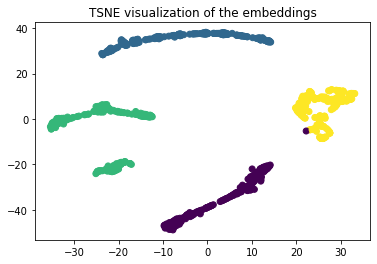

In [ ]:
embeddings_drugs, _, _ = dngr_pipeline(dd_net, N_rand_drugs, [500, 200, 100])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      DropoutNoise-1                 [-1, 1000]               0
            Linear-2                  [-1, 500]         500,500
           Sigmoid-3                  [-1, 500]               0
        BasicBlock-4                  [-1, 500]               0
            Linear-5                  [-1, 200]         100,200
           Sigmoid-6                  [-1, 200]               0
        BasicBlock-7                  [-1, 200]               0
            Linear-8                  [-1, 100]          20,100
           Sigmoid-9                  [-1, 100]               0
       BasicBlock-10                  [-1, 100]               0
           Linear-11                  [-1, 200]          20,200
          Sigmoid-12                  [-1, 200]               0
       BasicBlock-13                  [-1, 200]               0
           Linear-14                  [

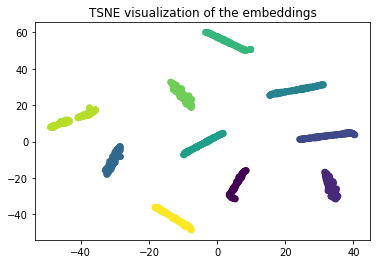

In [ ]:
embeddings_targets, _, _ = dngr_pipeline(pp_net, N_rand_targets, [500, 200, 100])

In [ ]:
pos_train, neg_train, pos_test, neg_test = train_test_split_pu(dp_net)
S, H, W =pu_learning(embeddings_drugs, embeddings_targets, dp_net, pos_train, neg_train, k=30, maxiter=100000, alpha=1, gamma=0.6)
S

Number of variables: 6000
Finding positive and negative examples...
Number of positive examples: 125242
Number of negative/unlabelled examples: 125234
Going to minimize... Maximum number of iterations: 100000
Objective:  tensor(69876.6406, device='cuda:0', grad_fn=<AddBackward0>)
Objective:  tensor(64939.7383, device='cuda:0', grad_fn=<AddBackward0>)
Objective:  tensor(63269.1016, device='cuda:0', grad_fn=<AddBackward0>)
Objective:  tensor(62871.4062, device='cuda:0', grad_fn=<AddBackward0>)
Objective:  tensor(62721.6992, device='cuda:0', grad_fn=<AddBackward0>)
Objective:  tensor(62651.5547, device='cuda:0', grad_fn=<AddBackward0>)
Objective:  tensor(62613.9766, device='cuda:0', grad_fn=<AddBackward0>)
Objective:  tensor(62592.4609, device='cuda:0', grad_fn=<AddBackward0>)
Objective:  tensor(62574.3203, device='cuda:0', grad_fn=<AddBackward0>)
Objective:  tensor(62562.9727, device='cuda:0', grad_fn=<AddBackward0>)
Objective:  tensor(63237.1016, device='cuda:0', grad_fn=<AddBackward0>)

(tensor([[0.4975, 0.4962, 0.5179,  ..., 0.5141, 0.5132, 0.4975],
         [0.5112, 0.5180, 0.5163,  ..., 0.5188, 0.5176, 0.5112],
         [0.5120, 0.4984, 0.4671,  ..., 0.4976, 0.4967, 0.5120],
         ...,
         [0.5049, 0.4919, 0.5091,  ..., 0.5159, 0.5150, 0.5049],
         [0.5307, 0.4736, 0.4854,  ..., 0.5387, 0.5376, 0.5307],
         [0.4913, 0.4901, 0.5073,  ..., 0.4924, 0.4914, 0.4913]],
        device='cuda:0', grad_fn=<MmBackward>),
 tensor([[ 0.0103, -0.0097, -0.0040,  ..., -0.0288, -0.0077, -0.0143],
         [ 0.0003, -0.0077,  0.0003,  ..., -0.0205, -0.0397, -0.0330],
         [ 0.0058, -0.0217, -0.0168,  ...,  0.0040,  0.0094,  0.0140],
         ...,
         [-0.0226, -0.0037, -0.0160,  ..., -0.0101, -0.0056,  0.0158],
         [ 0.0030,  0.0089, -0.0051,  ..., -0.0051, -0.0101, -0.0190],
         [ 0.0297, -0.0012,  0.0153,  ...,  0.0242,  0.0399,  0.0281]],
        device='cuda:0', requires_grad=True),
 tensor([[ 0.0738,  0.0767,  0.0040,  ...,  0.0953,  0.0444,

In [ ]:
test = torch.logical_or(pos_test, neg_test)
train = torch.logical_or(pos_train, neg_train)

print(torch.sum(test), torch.sum(train))
print(torch.std(S), torch.std(S[test]), torch.std(S[train]))

tensor(533524) tensor(250476)
tensor(0.0193, device='cuda:0', grad_fn=<StdBackward0>) tensor(0.0192, device='cuda:0', grad_fn=<StdBackward0>) tensor(0.0193, device='cuda:0', grad_fn=<StdBackward0>)


In [ ]:
def binarize(S, threshold=0.5):
    P = (S > threshold).float()
    return(P)

In [ ]:
P=binarize(S[0])
dp_net=torch.Tensor(dp_net)

TP=dp_net==1
print(TP)

print(P[TP].size())
print(torch.sum(TP))

torch.sum(abs(P[TP]-1))

tensor([[False, False,  True,  ...,  True,  True,  True],
        [ True, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False],
        ...,
        [ True, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True, False,  True],
        [ True,  True,  True,  ..., False, False, False]])
torch.Size([156577])
tensor(156577)


tensor(73420., device='cuda:0')

In [ ]:
from sklearn.metrics import roc_auc_score

y_pred = S.reshape((-1,))
y_true = dd_net.reshape((-1,))

roc_auc_score(y_true, y_pred)

(1568000, 2)


ValueError: ignored

# [References]

[1] X. Zeng, S. Zhu, W. Lu, Z. Liu, J. Huang, Y. Zhou, J. Fang, Y. Huang, H. Guo, L. Li, B. D. Trapp, R. Nussinov, C. Eng, J. Loscalzo, F. Cheng, Target identification among known drugs by deep learning from heterogeneous networks. Chem. Sci.11, 1775–1797 (2020).

[2] Shaosheng Cao, Wei Lu, and Qiongkai Xu. 2016. Deep neural networks for learning graph representations. In Proceedings of the Thirtieth AAAI Conference on Artificial Intelligence (AAAI'16). AAAI Press, 1145–1152.